In [ ]:
# Standard library
import os
import yaml
import random
from PIL import Image
from pathlib import Path
import sys

# Define root path
ROOT_PATH = Path(os.getcwd()).resolve().parent.parent
sys.path.insert(0, str(ROOT_PATH))

# Third party packages
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Subset

# My custom packages: Convolutional Autoencoder and Dataset definition
from bird_detector.data.data_loaders import SimpleBirdDataset
from bird_detector.autoencoder import ConvAutoencoder

# Bird Photo Anomaly Detection Pipeline

## Overview
**Goal**: Find anomalous bird photos in a dataset so I can check them in Lightroom and edit if needed.

**Method**: Train a convolutional autoencoder on a random subject of images, then flag photos that have high reconstruction error. This subset might contain pictures of birds but they are so few and far between that I will assume that it won't affect what the model will learn.

## 1. Configuration and Model Setup

Load experiment configuration and initialize the convolutional autoencoder.

In [2]:
# Load experiment configuration
with open('conv-ae-config.yaml') as f:
  config = yaml.safe_load(f)
model_config = config['model']
training_config = config['training']
data_config = config['data']
model_metadata = config['model_metadata']
model_config['image_size'] = data_config['image_size']

print("Configuration loaded:")
print(f"  Model: ConvAutoencoder with {model_config['latent_dim']}D latent space")
print(f"  Image size: {data_config['image_size']}x{data_config['image_size']}")
print(f"  Training: {data_config['train_frac']*100}% of data")
print(f"  Validation: {data_config['val_frac']*100}% of data")

Configuration loaded:
  Model: ConvAutoencoder with 2D latent space
  Image size: 64x64
  Training: 40.0% of data
  Validation: 10.0% of data


## 2. Data Loading and Splitting

Create reproducible train/validation splits using a fixed seed.
The remaining data will be used for the final anomaly detection on the full dataset.

In [3]:
# Set fixed seeds for reproducible splits
SEED = config['seed']
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

IMAGE_SIZE = data_config['image_size']

# Load full dataset
print("Loading dataset...")
dataset_path = ROOT_PATH / data_config['path']
print(f"Dataset path: {dataset_path}")

# Check if directory exists
if not dataset_path.exists():
    print(f"❌ Error: Dataset directory does not exist: {dataset_path}")
    print("Please check the path and ensure the data directory exists.")
    raise FileNotFoundError(f"Dataset directory not found: {dataset_path}")

full_dataset = SimpleBirdDataset(str(dataset_path), IMAGE_SIZE)
print(f"Full dataset size: {len(full_dataset)} images")

# Check if we have any images
if len(full_dataset) == 0:
    print("❌ Error: No images found in the dataset directory!")
    print(f"Please check that {dataset_path} contains .jpg files.")
    raise ValueError("No images found in dataset directory")

# Create three-way split: 20% train, 30% validation
total_size = len(full_dataset)
train_size = int(data_config['train_frac'] * total_size)  # 20% for training
val_size = int(data_config['val_frac'] * total_size)      # 30% for validation
test_size = total_size - train_size - val_size

# Create indices and shuffle them with fixed seed
indices = list(range(total_size))
random.shuffle(indices)

# Split indices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

print(f"Training set: {len(train_indices)} images ({len(train_indices)/total_size*100:.1f}%)")
print(f"Validation set: {len(val_indices)} images ({len(val_indices)/total_size*100:.1f}%)")
print(f"Remaining: {len(test_indices)} images ({len(test_indices)/total_size*100:.1f}%)")

# Create subsets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)
train_and_val_dataset = Subset(full_dataset, indices[:train_size + val_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
full_dataloader = DataLoader(full_dataset, batch_size=8, shuffle=False, num_workers=0)  # Batch size 8 for field test
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)  # Batch size 8 for field test
train_and_val_dataloader = DataLoader(train_and_val_dataset, batch_size=8, shuffle=False, num_workers=0)  # Batch size 8 for field test

Loading dataset...
Dataset path: C:\Users\ray\Desktop\code\2025\2_summer_2025\bird_watching\exploration\data\interim\jpg256_set3
Full dataset size: 4029 images
Training set: 1611 images (40.0%)
Validation set: 402 images (10.0%)
Remaining: 2016 images (50.0%)


## 3. Model Training

Train the convolutional autoencoder to learn normal background patterns.
The model will learn to compress and reconstruct background images efficiently.

In [4]:
from bird_detector.autoencoder import get_loss_function, get_optimizer

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ConvAutoencoder(**model_config).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

loss_fn = get_loss_function(training_config['loss_fn'])
optimizer = get_optimizer(training_config['optimizer'], model.parameters(), lr=training_config['lr'])

Using device: cuda
Total parameters: 57,037

Using class LogMSELoss as loss.


In [5]:
# Train the model with early stopping
from bird_detector.autoencoder import train_model

print("Starting model training...")
results = train_model(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    loss_fn,
    training_config,
    metrics_to_track=['loss', 'mse'],
    device=device
)

# Extract training results
print("\nTraining completed!")
print("Available metrics:", "\n".join(results.keys()))

final_train_loss = results['final_train_loss']
best_train_loss = results['best_train_loss']
final_val_loss = results['final_val_loss']
best_val_loss = results['best_val_loss']
validation_losses = results['validation_loss_vals']
training_losses = results['training_loss_vals']
time_elapsed_sec = results['time_elapsed_sec']
training_mse_vals = results['training_mse_vals']
validation_mse_vals = results['validation_mse_vals']

print(f"\nTraining Summary:")
print(f"  Total Time: {int(time_elapsed_sec)} seconds")
print(f"  Epochs trained: {results.get('epochs_trained', 'N/A')}")
print(f"  Best validation loss: {best_val_loss:.6f}")
print(f"  Final validation loss: {final_val_loss:.6f}")

Starting model training...

Using class LogMSELoss as loss.
Starting training...


Epochs: 100%|██████████| 50/50 [03:18<00:00,  3.98s/it]

Restored best model with validation loss: -3.454389

Training completed!
Available metrics: time_elapsed_sec
epochs_trained
best_val_loss
final_train_loss
best_train_loss
final_val_loss
training_loss_vals
validation_loss_vals
final_train_mse
best_train_mse
final_val_mse
best_val_mse
training_mse_vals
validation_mse_vals

Training Summary:
  Total Time: 198 seconds
  Epochs trained: 50
  Best validation loss: -3.454389
  Final validation loss: -3.437336


## 4. Training Progress Visualization

Visualize how well the model is learning over time.

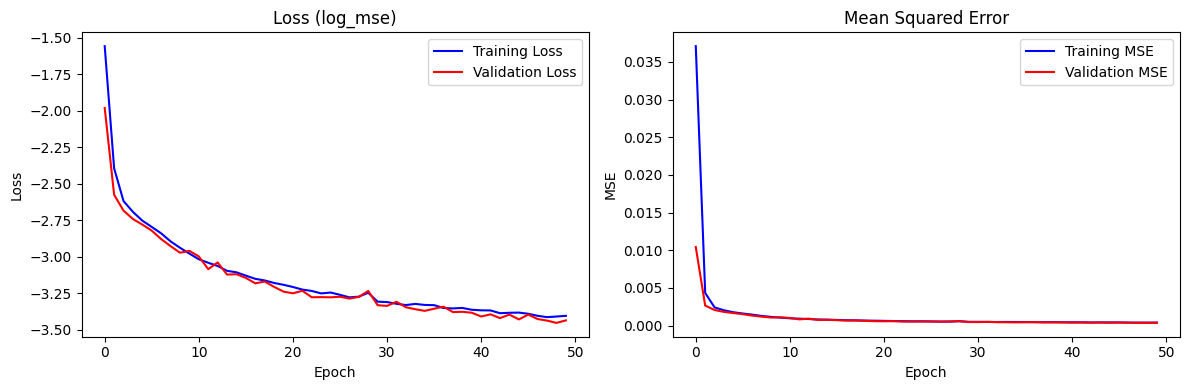

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss curves
ax[0].plot(training_losses, label='Training Loss', color='blue')
ax[0].plot(validation_losses, label='Validation Loss', color='red')
ax[0].set_title(f'Loss ({training_config["loss_fn"]})')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot MSE curves
ax[1].plot(training_mse_vals, label='Training MSE', color='blue')
ax[1].plot(validation_mse_vals, label='Validation MSE', color='red')
ax[1].set_title('Mean Squared Error')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('MSE')
ax[1].legend()

plt.tight_layout()
plt.show()

## 5. Localized Anomaly Scoring

Use a **localized scoring method**:

1. **Difference Map**: Compute pixel-wise difference between original and reconstructed images
2. **Gaussian Smoothing**: Apply Gaussian convolution to reduce noise
3. **Max Pooling**: Progressively downsample to 4x4, keeping the maximum value in each region
4. **Peak Detection**: Return the highest value as the anomaly score

This method is more sensitive to localized anomalies (like birds) while being robust to global lighting variations.

Computing localized anomaly scores on train+validation dataset...
This establishes the baseline distribution for Otsu thresholding.


0it [00:00, ?it/s]

c:\Users\ray\Desktop\code\2025\2_summer_2025\bird_watching\exploration\.venv\Lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(


Otsu method took 4.22 ms

Anomaly Score Statistics (Train+Validation Set):
  Mean: -2.876642
  Min:  -3.442855
  Max:  -0.450971
  Std:  0.370700
  Otsu Threshold: -1.962024


Text(0.5, 1.0, 'Anomaly Scores')

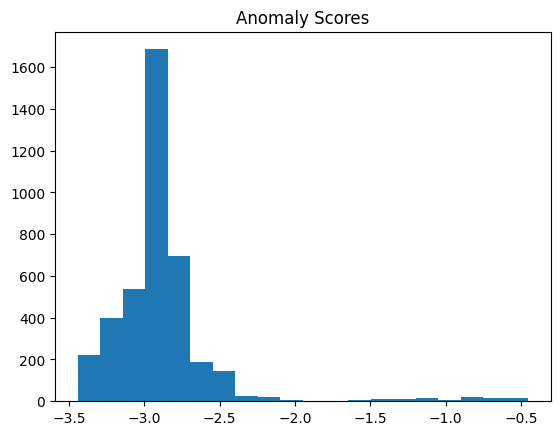

In [7]:
from bird_detector.autoencoder.otsu_method import otsu_method
from bird_detector.autoencoder.scores import localized_reconstruction_score
from tqdm.notebook import tqdm

print("Computing localized anomaly scores on train+validation dataset...")
print("This establishes the baseline distribution for Otsu thresholding.")

model.eval()  # Ensure model is in evaluation mode
anomaly_scores = []
val_filenames = []

with torch.no_grad():
    for batch_idx, (data, filenames) in tqdm(enumerate(full_dataloader)):
        data = data.to(device)
        output = model(data)
        diff_batch = output - data  # Shape: [N, C, H, W] (e.g., [16, 3, 64, 64])

        # Calculate localized anomaly scores
        batch_anomaly_scores = localized_reconstruction_score(
            diff_batch=torch.abs(diff_batch),
            original_image_size=data_config['image_size'],
            gaussian_kernel_size=10,
            gaussian_sigma=1.0,
            device=device
        )
        batch_anomaly_scores = torch.log(batch_anomaly_scores)
        anomaly_scores.extend(batch_anomaly_scores.cpu().numpy().tolist())
        val_filenames.extend(filenames)

anomaly_scores = np.array(anomaly_scores)

# Apply Otsu method to automatically determine optimal threshold
from time import perf_counter_ns
otsu_t1 = perf_counter_ns()
anomaly_threshold = otsu_method(anomaly_scores)
otsu_t2 = perf_counter_ns()
print(f"Otsu method took {(otsu_t2 - otsu_t1) * 1e-6:.2f} ms")


print(f"\nAnomaly Score Statistics (Train+Validation Set):")
print(f"  Mean: {anomaly_scores.mean():.6f}")
print(f"  Min:  {anomaly_scores.min():.6f}")
print(f"  Max:  {anomaly_scores.max():.6f}")
print(f"  Std:  {anomaly_scores.std():.6f}")
print(f"  Otsu Threshold: {anomaly_threshold:.6f}")

plt.hist(anomaly_scores, 20)
plt.title('Anomaly Scores')

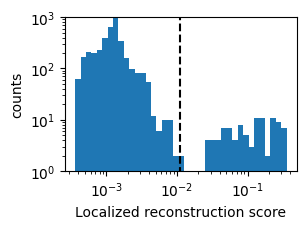

In [8]:
array = 10**np.asarray(anomaly_scores).astype(np.float32)

fig, ax = plt.subplots(figsize=(3,2))
ax.hist(array, bins=np.geomspace(array.min(), array.max(), 40))
ax.vlines(10**anomaly_threshold, ymin=1e-5, ymax=1000, colors='k', linestyle='dashed')
ax.set_xlabel('Localized reconstruction score')
ax.set_ylabel('counts')
plt.ylim(1,1e3)
plt.xscale('log')
plt.yscale('log')

output_path = Path('C:/Users/ray/Desktop/code/website/blowfish-website/content/posts/bird-watching-anomaly-detection/reconstruction_score_histogram.svg')
plt.savefig(output_path, bbox_inches='tight')
# plt.show()
# plt.close()

## 6. Full Dataset Anomaly Detection

Now apply the trained model and Otsu threshold to the **entire dataset** to find bird photos.
This is the key step - we're testing on the full dataset, not just a test split.

In [9]:
import torch
import torch.nn as nn
import numpy as np
import math
from torchvision import transforms
from bird_detector.autoencoder.otsu_method import otsu_method
from bird_detector.autoencoder.scores import localized_reconstruction_score
from tqdm.notebook import tqdm

print("Finding anomalies in the FULL dataset...")
print("This is the field test - applying our model to all images.")

model.eval()  # Ensure model is in evaluation mode
anomalous_filenames = []
anomalous_images = []

with torch.no_grad():
    for batch_idx, (imgs, filenames) in tqdm(enumerate(full_dataloader), desc="Processing full dataset"):
        imgs = imgs.to(device)
        output = model(imgs)
        diff_batch = output - imgs  # Shape: [N, C, H, W] (e.g., [16, 3, 64, 64])

        # Calculate localized anomaly scores
        batch_anomaly_scores = localized_reconstruction_score(
            diff_batch=torch.abs(diff_batch),
            original_image_size=data_config['image_size'],
            gaussian_kernel_size=10,
            gaussian_sigma=1.0,
            device=device
        )
        batch_anomaly_scores = torch.log(batch_anomaly_scores)

        # Flag images above the Otsu threshold
        for (img, score, filename) in zip(imgs, batch_anomaly_scores, filenames):
            if score > anomaly_threshold:
                anomalous_filenames.append(filename)
                anomalous_images.append(transforms.ToPILImage()(img.cpu()))

print(f"\nAnomaly Detection Results:")
print(f"  Total images processed: {len(full_dataset)}")
print(f"  Anomalies found: {len(anomalous_filenames)}")
print(f"  Anomaly rate: {len(anomalous_filenames)/len(full_dataset)*100:.2f}%")

Finding anomalies in the FULL dataset...
This is the field test - applying our model to all images.


Processing full dataset: 0it [00:00, ?it/s]


Anomaly Detection Results:
  Total images processed: 4029
  Anomalies found: 100
  Anomaly rate: 2.48%


## 7. Visualize Detected Anomalies

Display all the anomalous images that were flagged by our system.
These should be the bird photos in your dataset.

Visualizing 100 anomalous images...


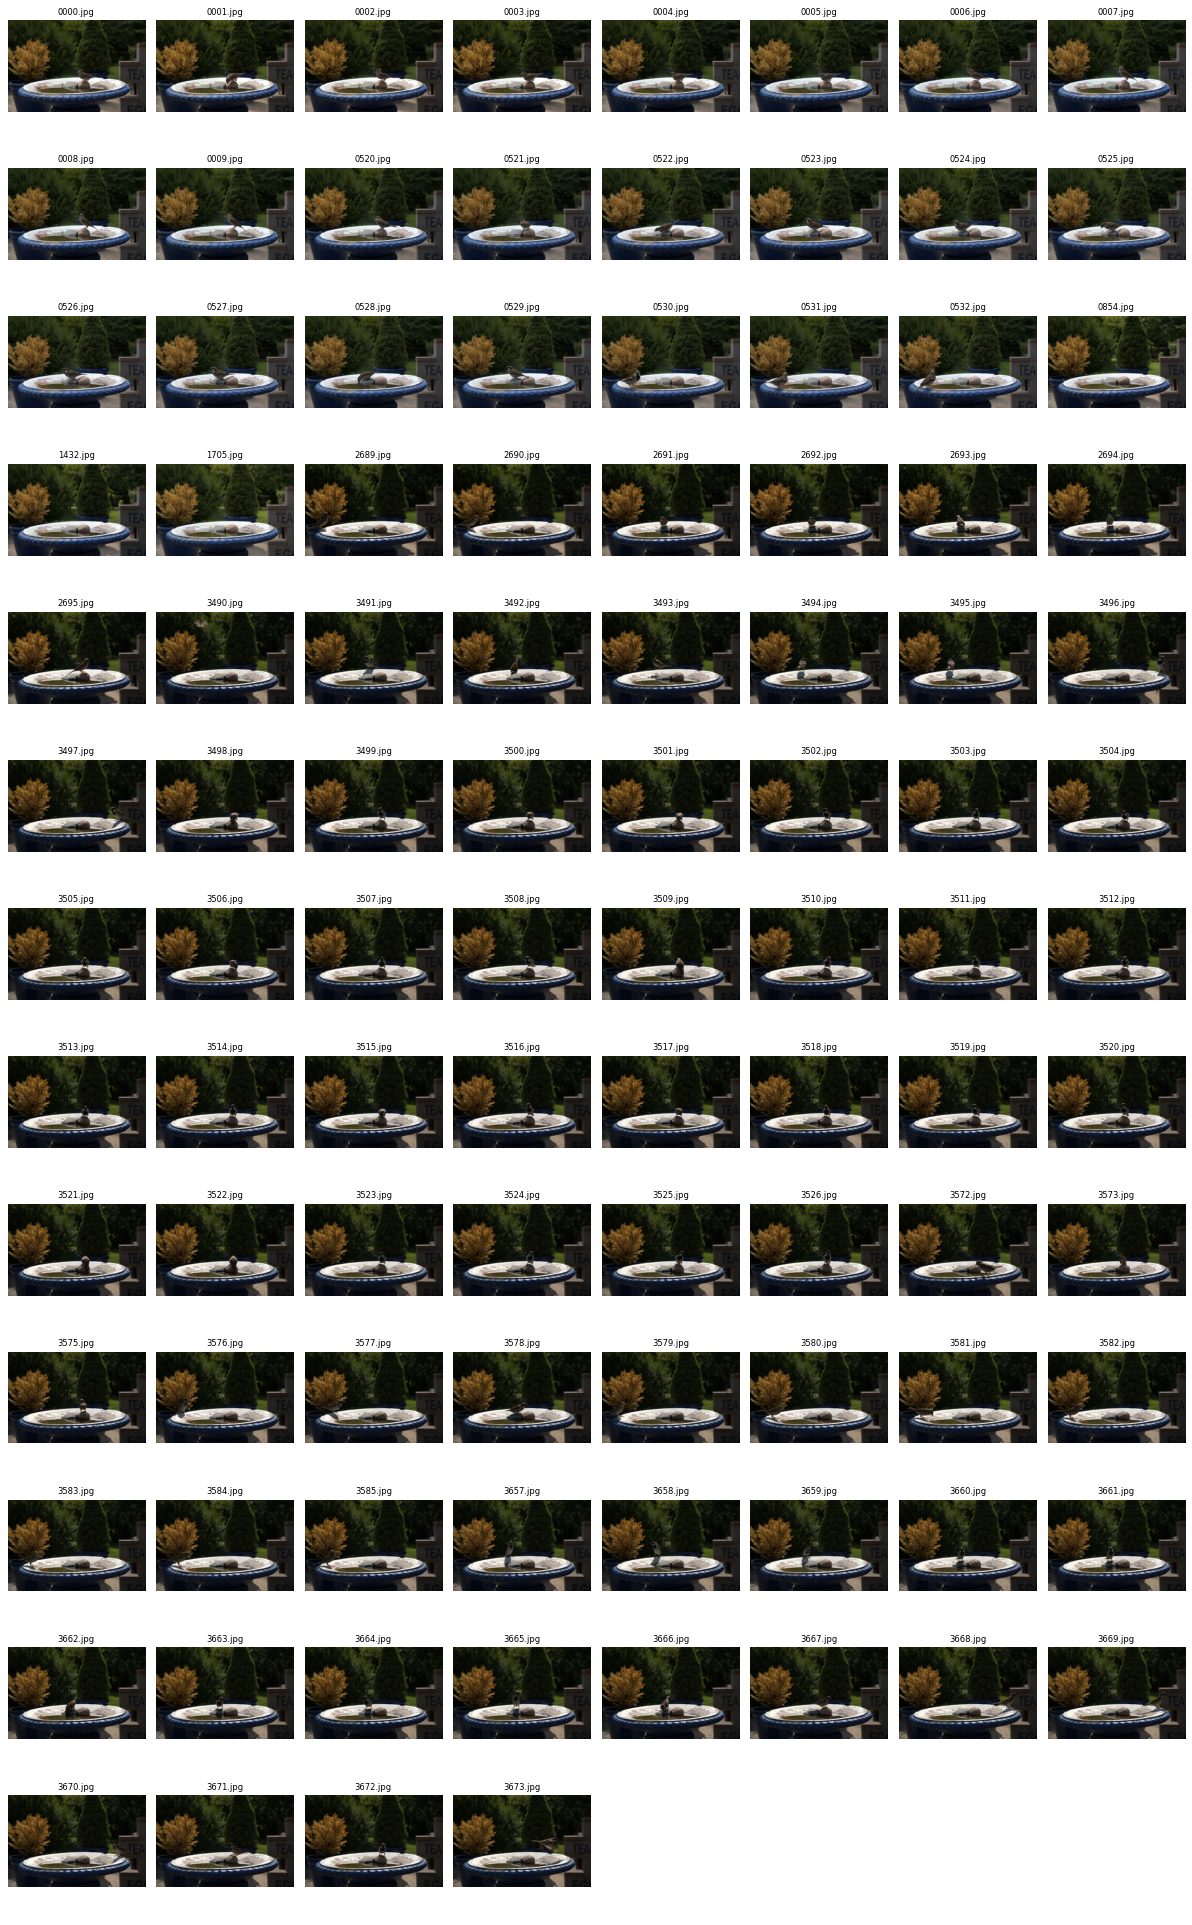

Displayed 100 anomalous images
These should be the bird photos in your dataset!


In [10]:
# Plot all anomalous images
_anomalous_images = [Image.open(ROOT_PATH / data_config['path'] / filename) for filename in anomalous_filenames]

if len(_anomalous_images) > 0:
    print(f"Visualizing {len(_anomalous_images)} anomalous images...")
    
    # Calculate grid dimensions
    n_images = len(_anomalous_images)
    cols = min(8, n_images)  # Max 8 columns
    rows = (n_images + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2), dpi=75)
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, (image, filename) in enumerate(zip(_anomalous_images, anomalous_filenames)):
        row = i // cols
        col = i % cols
        
        img_display = image
        
        axes[row, col].imshow(img_display)
        axes[row, col].set_title(f'{filename}', fontsize=8)
        axes[row, col].axis('off')
    
    # Hide empty subplots
    for i in range(n_images, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Displayed {len(_anomalous_images)} anomalous images")
    print("These should be the bird photos in your dataset!")
else:
    print("No anomalies to display!")

## 8. Latent Space Analysis

Visualize how the model organizes images in its 2D latent space.
This helps understand how the autoencoder separates normal background images from anomalies.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

# Set model to evaluation mode
model.eval()

# Initialize lists to store latent space representations
normal_latent_vecs = []
anomaly_latent_vecs = []

print("Mapping images to latent space and classifying by anomaly score...")

with torch.no_grad():
    for images, _ in tqdm(full_dataloader, desc="Processing batches"):
        images = images.to(device)

        # Encode images to latent space
        encoded_batch = model.encoder(images).cpu().numpy()

        # Decode images for reconstruction error calculation
        reconstructions = model(images)

        # Calculate the reconstruction difference
        diff_batch = reconstructions - images

        # Calculate anomaly scores for the batch
        scores = localized_reconstruction_score(
            diff_batch=torch.abs(diff_batch),
            original_image_size=data_config['image_size'],
            gaussian_kernel_size=10,
            gaussian_sigma=1.0,
            device=device
        )
        scores = torch.log(scores).cpu().numpy()

        # Categorize latent vectors based on anomaly score threshold
        for score, encoded_vec in zip(scores, encoded_batch):
            if score <= anomaly_threshold:
                normal_latent_vecs.append(encoded_vec)
            else:
                anomaly_latent_vecs.append(encoded_vec)

# Convert lists to NumPy arrays
normal_latent_vecs = np.array(normal_latent_vecs)
anomaly_latent_vecs = np.array(anomaly_latent_vecs)
latent_space_vals = np.concatenate([anomaly_latent_vecs, normal_latent_vecs])

print(f"Normal samples in latent space: {normal_latent_vecs.shape[0]}")
print(f"Anomaly samples in latent space: {anomaly_latent_vecs.shape[0]}")

Mapping images to latent space and classifying by anomaly score...


Processing batches:   0%|          | 0/504 [00:00<?, ?it/s]

Normal samples in latent space: 3929
Anomaly samples in latent space: 100


## 9. Latent Space Visualization

Plot the distribution of images in the 2D latent space, colored by anomaly status.

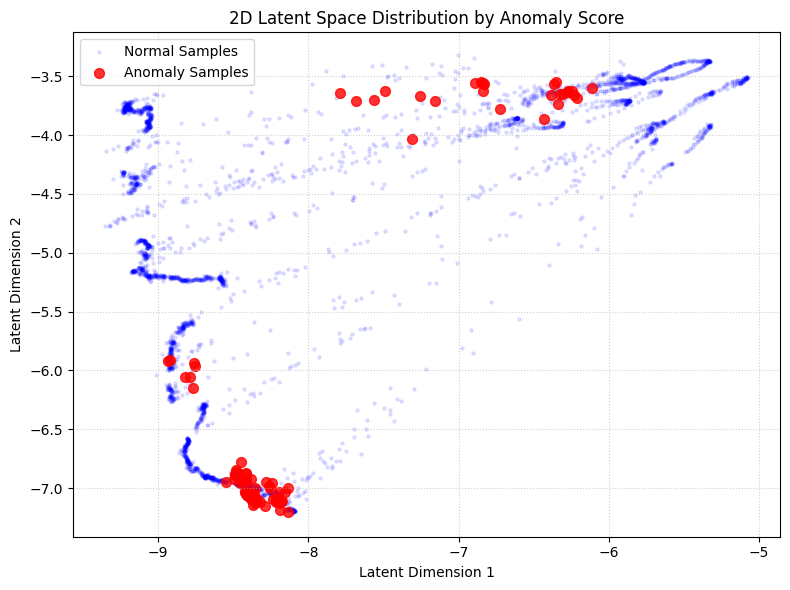


Latent space visualization complete.


In [12]:
# Plot Latent Space Distribution
fig, ax = plt.subplots(figsize=(8, 6))

if model_config['latent_dim'] == 1:
    # Flatten latent vectors for 1D histogram
    normal_vals = normal_latent_vecs.flatten()
    anomaly_vals = anomaly_latent_vecs.flatten()

    if normal_vals.size > 0:
        ax.hist(normal_vals, bins=50, alpha=0.7, color='blue', label='Normal Samples')
    if anomaly_vals.size > 0:
        ax.hist(anomaly_vals, bins=50, alpha=0.7, color='red', label='Anomaly Samples')

    ax.set_xlabel('Latent Space Value')
    ax.set_ylabel('Count')
    ax.set_title('1D Latent Space Distribution by Anomaly Score')
    ax.legend()

elif model_config['latent_dim'] == 2:
    # Reshape latent vectors for 2D scatter plot
    normal_2d_vecs = normal_latent_vecs.reshape(-1, 2)
    anomaly_2d_vecs = anomaly_latent_vecs.reshape(-1, 2)

    # Plot only if arrays are not empty
    if normal_2d_vecs.shape[0] > 0:
        ax.scatter(normal_2d_vecs[:, 0], normal_2d_vecs[:, 1], s=5, alpha=0.1, c='blue', label='Normal Samples')
    if anomaly_2d_vecs.shape[0] > 0:
        ax.scatter(anomaly_2d_vecs[:, 0], anomaly_2d_vecs[:, 1], s=50, alpha=0.8, c='red', label='Anomaly Samples')

    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.set_title('2D Latent Space Distribution by Anomaly Score')
    ax.legend()

else:
    print(f"Warning: Latent space dimension {model_config['latent_dim']} not supported for direct visualization.")
    print("This script currently supports 1D or 2D latent space visualizations.")

plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nLatent space visualization complete.")

## 10. Interactive Latent Space Exploration

Interactive tools to explore the latent space and understand how the model organizes different types of images.

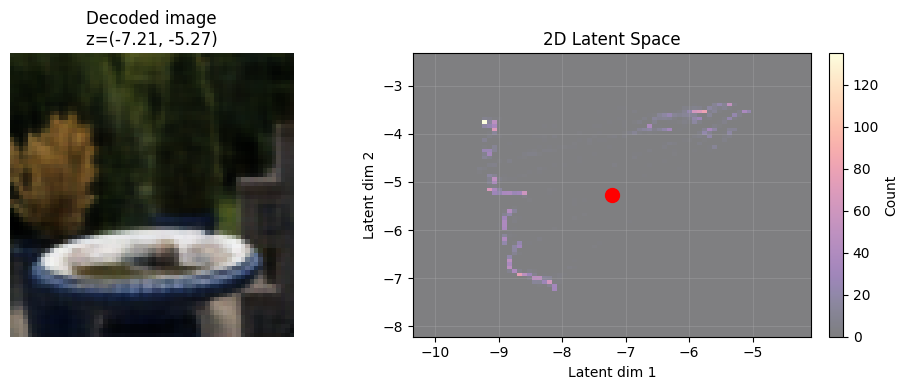

IndexError: list index out of range

<Figure size 640x480 with 0 Axes>

In [13]:
from bird_detector.autoencoder.interactive_utils import interactive_1d_latent_space, interactive_2d_latent_space

# Interactive exploration
if model_config['latent_dim'] == 1:
    z_min = float(np.min(latent_space_vals))
    z_max = float(np.max(latent_space_vals))
    z_initial = 0.5 * (z_min + z_max)
    interactive_1d_latent_space(model, model_config, z_min=z_min, z_max=z_max, z_initial=z_initial)
elif model_config['latent_dim'] == 2:
    model_config['input_size'] = data_config['image_size']
    x_min, x_max = float(np.min(latent_space_vals[:, 0])), float(np.max(latent_space_vals[:, 0]))
    y_min, y_max = float(np.min(latent_space_vals[:, 1])), float(np.max(latent_space_vals[:, 1]))
    boundaries = [x_min - 1, x_max + 1, y_min - 1, y_max + 1]
    interactive_2d_latent_space(model, model_config, boundaries, latent_space_vals=latent_space_vals, hist_kwargs={'cmap': 'magma', 'bins': 80})
    fig = plt.gcf()
    ax = fig.axes[1]
    ax.vlines([x_min, x_max], ymin=y_min, ymax=y_max, colors='r')
    ax.hlines([y_min, y_max], xmin=x_min, xmax=x_max, colors='r')

In [ ]:
from bird_detector.autoencoder.interactive_utils import interactive_1d_latent_space, interactive_2d_latent_space

# Interactive exploration
if model_config['latent_dim'] == 1:
    z_min = float(np.min(latent_space_vals))
    z_max = float(np.max(latent_space_vals))
    z_initial = 0.5 * (z_min + z_max)
    interactive_1d_latent_space(model, model_config, z_min=z_min, z_max=z_max, z_initial=z_initial)
elif model_config['latent_dim'] == 2:
    model_config['input_size'] = data_config['image_size']
    x_min, x_max = float(np.min(latent_space_vals[:, 0])), float(np.max(latent_space_vals[:, 0]))
    y_min, y_max = float(np.min(latent_space_vals[:, 1])), float(np.max(latent_space_vals[:, 1]))
    boundaries = [x_min - 3, x_max + 3, y_min - 3, y_max + 3]
    interactive_2d_latent_space(model, model_config, boundaries, latent_space_vals=latent_space_vals, hist_kwargs={'cmap': 'magma', 'bins': 80})
    fig = plt.gcf()
    ax = fig.axes[1]
    ax.vlines([x_min, x_max], ymin=y_min, ymax=y_max, colors='r')
    ax.hlines([y_min, y_max], xmin=x_min, xmax=x_max, colors='r')